## State Graph 개요
정의: state를 기반으로 작동하는 그래프 구조
목적: 복잡한 작업 흐름을 상태와 전이로 모델링하여 유연하고 제어 가능한 시스템 구축
특징: 각 노드가 특정 상태를 나타내며, 엣지가 상태 간 전이 조건을 정의

### State: 애플리케이션의 현재 스냅샷을 나타내는 구조
#### 특징:
- 주로 TypeDict나 Pydantic BaseModel을 사용

###  노드: Agent의 로직을 인코딩하는 함수
#### 특징:
- 현재 State를 입력으로 받고, 작업을 수행한 다음 업데이트된 State를 반환

### Edge: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 함수
#### 특징: 
- 조건부 분기, 고정 전이
- 시스템의 흐름을 제어

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import  re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
from typing import TypedDict

# 상태 Schema 정의 - 사용자의 선호도, 추천된 메뉴, 그리고 메뉴 정보를 저장
class MenuState(TypedDict):
    user_preference: str
    recommended_menu: str
    menu_info: str

In [4]:
import random

def get_user_preference(state: MenuState) -> MenuState:
    print("---랜덤 사용자 선호도 생성---")
    preferences = ["육류", "해산물", "채식", "아무거나"]
    preference = random.choice(preferences)
    print(f"생성된 선호도: {preference}")
    return {"user_preference": preference}

def recommend_menu(state: MenuState) -> MenuState:
    print("---메뉴 추천---")
    preference = state['user_preference'] # user_preference를 가져옴
    if preference == "육류":
        menu = "스테이크"
    elif preference == "해산물":
        menu = "랍스터 파스타"
    elif preference == "채식":
        menu = "그린 샐러드"
    else:
        menu = "오늘의 쉐프 특선"
    print(f"추천 메뉴: {menu}")
    return {"recommended_menu": menu}

def provide_menu_info(state: MenuState) -> MenuState:
    print("---메뉴 정보 제공---")
    menu = state['recommended_menu']
    if menu == "스테이크":
        info = "최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원"
    elif menu == "랍스터 파스타":
        info = "신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원"
    elif menu == "그린 샐러드":
        info = "신선한 유기농 채소로 만든 건강한 샐러드. 가격: 15,000원"
    else:
        info = "쉐프가 그날그날 엄선한 특별 요리입니다. 가격: 35,000원"
    print(f"메뉴 정보: {info}")
    return {"menu_info": info}

In [5]:
from langgraph.graph import StateGraph, START, END

# 그래프 빌더 생성
builder = StateGraph(MenuState)

# 노드 추가
builder.add_node("get_preference", get_user_preference)
builder.add_node("recommend", recommend_menu)
builder.add_node("provide_info", provide_menu_info)

# 엣지 추가
builder.add_edge(START, "get_preference")
builder.add_edge("get_preference", "recommend")
builder.add_edge("recommend", "provide_info")
builder.add_edge("provide_info", END)

# 그래프 컴파일
graph = builder.compile()

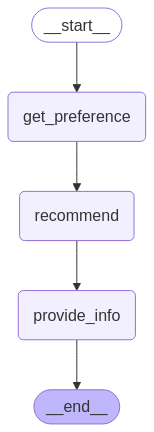

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
def print_result(result: MenuState):
    print("\n=== 결과 ===")
    print("선호도:", result['user_preference'])
    print("추천 메뉴:", result['recommended_menu'])
    print("메뉴 정보:", result['menu_info'])
    print("============\n")


inputs = {"user_preference": ""}

for _ in range(2):
    result = graph.invoke(inputs)
    print_result(result)
    print("*"*100)
    print()

---랜덤 사용자 선호도 생성---
생성된 선호도: 육류
---메뉴 추천---
추천 메뉴: 스테이크
---메뉴 정보 제공---
메뉴 정보: 최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원

=== 결과 ===
선호도: 육류
추천 메뉴: 스테이크
메뉴 정보: 최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원

****************************************************************************************************

---랜덤 사용자 선호도 생성---
생성된 선호도: 아무거나
---메뉴 추천---
추천 메뉴: 오늘의 쉐프 특선
---메뉴 정보 제공---
메뉴 정보: 쉐프가 그날그날 엄선한 특별 요리입니다. 가격: 35,000원

=== 결과 ===
선호도: 아무거나
추천 메뉴: 오늘의 쉐프 특선
메뉴 정보: 쉐프가 그날그날 엄선한 특별 요리입니다. 가격: 35,000원

****************************************************************************************************



## 조건부 엣지를 활용한 분기

### 정의: 현재 상태나 입력에 따라 다음 노드를 동적으로 결정하는 연결
### 목적: 시스템의 흐름을 더 유연하고 상황에 맞게 제어
### 특징: 조건문을 사용하여 다음 실행할 노드를 선택

In [26]:
from typing import TypedDict, List

class MenuState(TypedDict):
    user_query: str
    is_menu_related: bool
    search_results: List[str]
    final_answer: str

# state 스키마 
# class MenuState(TypedDict):
#     user_query: str
#     is_menu_related: bool
#     search_results: List[str]
#     final_answer: str

In [27]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings

embedding_model = OllamaEmbeddings(model="bge-m3")

vector_db = Chroma(
    embedding_function=embedding_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db"
)

In [28]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

def get_user_query(state: MenuState) -> MenuState:
    user_query = input("무엇을 도와드릴까요? ")
    return {"user_query": user_query}

def analyze_input(state: MenuState) -> MenuState:
    analyze_template = """
    사용자의 입력을 분석하여 레스토랑 메뉴 추천이나 음식 정보에 관한 질문인지 판단하세요.

    사용자 입력: {user_query}

    레스토랑 메뉴나 음식 정보에 관한 질문이면 "True", 아니면 "False"로 답변하세요.

    답변:
    """
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    
    result = analyze_chain.invoke({"user_query": state['user_query']})
    is_menu_related = result.strip().lower() == "true"
    
    return {"is_menu_related": is_menu_related}

def search_menu_info(state: MenuState) -> MenuState:
    # 벡터저장소에서 최대 2개의 문서를 검색 
    results = vector_db.similarity_search(state['user_query'], k=2)
    search_results = [doc.page_content for doc in results]
    return {"search_results": search_results}

def generate_menu_response(state: MenuState) -> MenuState:
    response_template = """
    사용자 입력: {user_query}
    메뉴 관련 검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 메뉴 관련 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query'], "search_results": state['search_results']})
    print(f"\n메뉴 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}

def generate_general_response(state: MenuState) -> MenuState:
    response_template = """
    사용자 입력: {user_query}

    위 입력은 레스토랑 메뉴나 음식과 관련이 없습니다. 
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.

    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_answer = response_chain.invoke({"user_query": state['user_query']})
    print(f"\n일반 어시스턴트: {final_answer}")
    
    return {"final_answer": final_answer}

In [29]:
from typing import Literal

def decide_next_step(state: MenuState) -> Literal["search_menu_info", "generate_general_response"]:
    if state['is_menu_related']:
        return "search_menu_info"  
    else:
        return "generate_general_response"

In [30]:
from langgraph.graph import StateGraph, START, END

# 그래프 구성
builder = StateGraph(MenuState)

# 노드 추가
builder.add_node("get_user_query", get_user_query)
builder.add_node("analyze_input", analyze_input)
builder.add_node("search_menu_info", search_menu_info)
builder.add_node("generate_menu_response", generate_menu_response)
builder.add_node("generate_general_response", generate_general_response)

# 엣지 추가
builder.add_edge(START, "get_user_query")
builder.add_edge("get_user_query", "analyze_input")

# 조건부 엣지 추가
builder.add_conditional_edges(
    "analyze_input",
    decide_next_step,
    {
        "search_menu_info": "search_menu_info",
        "generate_general_response": "generate_general_response"
    }
)

builder.add_edge("search_menu_info", "generate_menu_response")
builder.add_edge("generate_menu_response", END)
builder.add_edge("generate_general_response", END)

# 그래프 컴파일
graph = builder.compile()

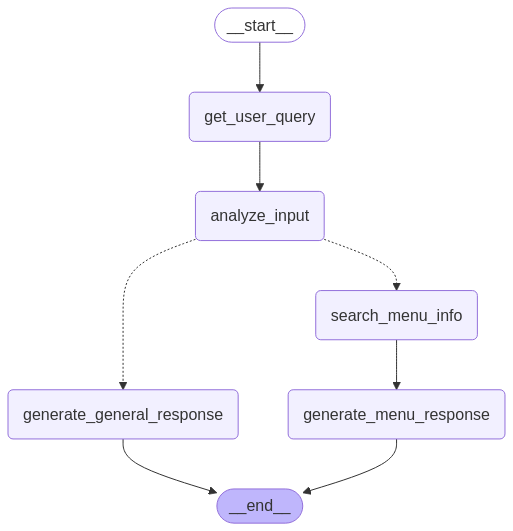

In [31]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
while True:
    initial_state = {'user_query':''}
    graph.invoke(initial_state) 
    continue_chat = input("다른 질문이 있으신가요? (y/n): ").lower()
    if continue_chat != 'y':
        print("대화를 종료합니다. 감사합니다!")
        break


메뉴 어시스턴트: 스테이크 가격에 대한 정보를 드리겠습니다. 현재 메뉴에는 두 가지 스테이크 옵션이 있습니다:

1. **시그니처 스테이크**
   - **가격:** ₩35,000
   - **주요 식재료:** 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   - **설명:** 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.

2. **안심 스테이크 샐러드**
   - **가격:** ₩26,000
   - **주요 식재료:** 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   - **설명:** 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.

원하시는 스테이크를 선택하시면 맛있는 식사를 즐기실 수 있습니다!
대화를 종료합니다. 감사합니다!
